In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import cv2
import json
import albumentations as alb
import numpy as np
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
cv2.__version__

In [3]:
!labelme

## Augment images

#### Note I've taken few pictures, splitted them into train and validation sets and made annotations using labelme. Now I'm going to multiply them using augmentation.

In [17]:
augmentor = alb.Compose([alb.Resize(512, 512, always_apply=True),
                         alb.RandomCrop(500, 500, p=0.5),
                       alb.HorizontalFlip(p=0.5),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='pascal_voc',
                                       label_fields=['class_labels']))

In [18]:
# testing the augmentor
test_img = cv2.imread(os.path.join('train', 'images', '0.jpg'))
h = tf.shape(test_img)[0]
w = tf.shape(test_img)[0]

In [19]:
file = open(os.path.join('train', 'labels', '0.json'), 'r')
label = json.load(file)
print(label['shapes'][0]['points'])
coords = tf.concat(label['shapes'][0]['points'], 0)
coords

[[233.00729927007302, 299.79562043795625], [255.63503649635038, 338.48175182481754]]


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([233.0073 , 299.79562, 255.63504, 338.48175], dtype=float32)>

In [20]:
augmented = augmentor(image=test_img, bboxes=[coords], class_labels=['cover'])
augmented

{'image': array([[[ 58,  65,  92],
         [ 57,  64,  91],
         [ 54,  63,  90],
         ...,
         [ 56,  71, 117],
         [ 58,  73, 119],
         [ 59,  74, 120]],
 
        [[ 56,  65,  92],
         [ 56,  65,  92],
         [ 55,  64,  91],
         ...,
         [ 56,  71, 117],
         [ 59,  72, 118],
         [ 60,  73, 119]],
 
        [[ 57,  66,  93],
         [ 57,  66,  93],
         [ 57,  66,  93],
         ...,
         [ 56,  71, 117],
         [ 58,  71, 117],
         [ 58,  71, 117]],
 
        ...,
 
        [[ 59,  80, 108],
         [ 60,  81, 109],
         [ 59,  81, 109],
         ...,
         [ 45,  48,  63],
         [ 43,  48,  63],
         [ 44,  49,  64]],
 
        [[ 59,  80, 108],
         [ 60,  81, 109],
         [ 59,  81, 109],
         ...,
         [ 44,  47,  62],
         [ 43,  48,  63],
         [ 44,  49,  64]],
 
        [[ 60,  81, 109],
         [ 60,  81, 109],
         [ 60,  81, 109],
         ...,
         [ 44,  47,

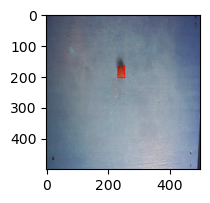

In [21]:
plt.figure(figsize=(4, 2))
cv2.rectangle(augmented['image'],
              np.array(augmented['bboxes'][0][:2]).astype(int),
              np.array(augmented['bboxes'][0][2:]).astype(int), (255, 0, 0), 2)

plt.imshow(augmented['image'])

In [22]:
# Augmentation fuction
def augment():
    for partition in ['train', 'val']:
        for image in os.listdir(os.path.join(partition, 'images')):
            label_path = os.path.join(partition, 'labels', f"{image.split('.')[0]}.json")
            img = cv2.imread(os.path.join(partition, 'images', image))
            h = tf.shape(img)[0]
            w = tf.shape(img)[1]
            if os.path.exists(label_path):
                with open(label_path) as f:
                    label = json.load(f)
                    
            coords = tf.concat(label['shapes'][0]['points'], 0)
        
            annotations = {}
        
            try:
                for i in range(60):
                    if os.path.exists(label_path):
                        augmented = augmentor(image=img, bboxes=[coords], class_labels = ['cover'])
                        cv2.imwrite(os.path.join('preprocessed_pic', partition, f'{image.split(".")[0]}.{i}.jpg'), augmented['image'])


                        annotations['filename'] = f'{image.split(".")[0]}.{i}.jpg'

                        if len(augmented['bboxes']) == 0:

                            annotations['bbox'] = [0, 0, 0, 0]
                            annotations['class'] = 0
                        else:
                            annotations['bbox'] = list(augmented['bboxes'][0])
                            annotations['class'] = 'cover'
                    
                    else:
                        augmented = augmentor(image=img, bboxes=[coords], class_labels = ['Donny'])
                        cv2.imwrite(os.path.join('preprocessed_pic', partition, f'{image.split(".")[0]}.{i}.jpg'), augmented['image'])


                        annotations['bbox'] = [0, 0, 0, 0]
                        annotations['class'] = 0

                    with open(os.path.join('preprocessed_pic', partition, f'{image.split(".")[0]}.{i}.json'), 'w') as f:
                        json.dump(annotations, f)


            except Exception as e:
                print(e)

In [23]:
augment()

## Create label map

In [2]:
# create labels for classification
label_map = 'label_map.pbtxt'
labels = [{'name':'cover', 'id':1}]

if not os.path.exists(label_map):
    with open(label_map, 'w') as f:
        for label in labels:
            f.write('item { \n')
            f.write(f"\tname: '{label['name']}' \n")
            f.write(f"\tid: {label['id']} \n")
            f.write('}\n')

## Create a TF record

In [25]:
# create tf record which will be used for training
tfrecord = os.path.join('Scripts', 'generate_tfrecord(json_augmented).py')
csv = os.path.join('csv', 'trainrec.csv')

In [27]:
!python {tfrecord} -j {os.path.join('preprocessed_pic', 'train')} -l {os.path.join(label_map)} -o {os.path.join('annotations', 'train.record')} -c {csv}
!python {tfrecord} -j {os.path.join('preprocessed_pic', 'val')} -l {os.path.join(label_map)} -o {os.path.join('annotations', 'val.record')}

Successfully created the TFRecord file: annotations\train.record
Successfully created the CSV file: csv\trainrec.csv
Successfully created the TFRecord file: annotations\val.record


## Configure pretrainied model

In [3]:
config_path = r'model_config\pipeline.config'

configs = config_util.get_configs_from_pipeline_file(config_path)

{'model': ssd {
   num_classes: 1
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [29]:
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [30]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(config_path, 'r') as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [31]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join('ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8', 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = 'detection'
pipeline_config.train_input_reader.label_map_path = label_map
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join('annotations', 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = label_map
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join('annotations', 'val.record')]

In [32]:
pipeline_config

model {
  ssd {
    num_classes: 1
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.9999998989515007e-05
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.009999999776482582
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
        additional_layer_depth: 128
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
 

In [33]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(config_path, 'wb') as f:
    f.write(config_text)

## Train the model

In [34]:
Training_script = r'C:\Users\SHOCKER\tensorflow_projects\models\research\object_detection\model_main_tf2.py'

In [35]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=5000".format(Training_script,
                                                                                             'model_config', config_path)
command

'python C:\\Users\\SHOCKER\\tensorflow_projects\\models\\research\\object_detection\\model_main_tf2.py --model_dir=model_config --pipeline_config_path=model_config\\pipeline.config --num_train_steps=5000'

In [15]:
!{command}

^C


## Load checkpoint

In [4]:
configs = config_util.get_configs_from_pipeline_file(config_path)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join('model_config', 'ckpt-6')).expect_partial()



In [5]:
@tf.function
def detect_image(image):
    images, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(images, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(label_map)

In [11]:
from scipy.spatial import distance as dist

def midpoint(coords):
    return ((coords[0] + coords[2])*0.5, (coords[1]+coords[3])*0.5)

def midline(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

## Show detections and try to find the distance between two covers

In [78]:
def display(frame):
    img = np.array(frame)
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    input_tensor = tf.convert_to_tensor(np.expand_dims(img, 0), dtype=tf.float32)

    scores = []
    coordinates = []
    detections = detect_image(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}


    detections['num_detections'] = num_detections

    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    for i in range(num_detections):
        if detections['detection_scores'][i]  > 0.7:
            scores.append(detections['detection_scores'][i])
            coordinates.append(detections['detection_boxes'][i])
    coords = {}
    midpoints = {}
    for i in range(len(coordinates)):
        coords[f"{i}"] = np.multiply(coordinates[i], [h, w, h, w])
        coords[f"{i}"] = coords[f"{i}"][::-1]
        midpoints[f"{i}"] = midpoint(coords[f"{i}"])
    
    pivot = midpoints['0']
    print(pivot)   
    for i in range(len(coords)):
        d = dist.euclidean(pivot, midpoints[f"{i}"])
        if d > 1.0:
            d_in_centimeters = d*(28.57/np.array(w))
    label_id_offset = 1
    image_np_with_detections = img.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes']+label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw = 5,
        min_score_thresh = 0.7,
        agnostic_mode=False
    )
    cv2.circle(image_np_with_detections, np.array(pivot).astype(int), 10, (240, 0, 159), -1)
    
    for i in range(len(midpoints) - 1):
        cv2.circle(image_np_with_detections, np.array(midpoints[f"{i+1}"]).astype(int), 10, (240, 0, 159), -1)
      
        cv2.line(image_np_with_detections, np.array(pivot).astype(int),
                 np.array(midpoints[f"{i+1}"]).astype(int), (240, 0, 159), 3)
        mx, my = midline(pivot, midpoints[f"{i+1}"])
        cv2.putText(image_np_with_detections, "{:.1f}cm".format(d_in_centimeters), (int(mx), int(my+20)),
               cv2.FONT_HERSHEY_SIMPLEX, 0.79, (240, 0, 159), 2)
        
    return image_np_with_detections

In [85]:
video_path = 'vid3.mp4'
src = cv2.VideoCapture(str(video_path))
video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

for i in range(150):
    ret, frame = src.read()
    if ret:
        cv2.imwrite('image.png', frame)
        image_np = display(frame)
        # Display output
        cv2.imshow('object detection', cv2.resize(image_np, (800, 600)))

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

src.release()
cv2.destroyAllWindows()
        

(1027.9853439331055, 549.3960785865784)
(1020.2499675750732, 549.5605516433716)
(1014.7858428955078, 549.1050964593887)
(1009.3914413452148, 549.3159180879593)
(1006.882209777832, 550.0451517105103)
(1000.1617813110352, 549.8967558145523)
(998.0574131011963, 551.5611362457275)
(985.1931095123291, 554.5287483930588)
(977.0895481109619, 557.9789972305298)
(972.1593475341797, 559.0154027938843)
(967.9445171356201, 566.0334938764572)
(965.7195281982422, 570.0502252578735)
(967.1874332427979, 573.8768792152405)
(961.9137954711914, 579.2887669801712)
(965.593957901001, 579.9753856658936)
(966.2694454193115, 581.4763230085373)
(966.0959243774414, 583.3514446020126)
(966.6233825683594, 584.5263808965683)
(967.9680919647217, 585.1937359571457)
(969.8939895629883, 584.5196056365967)
(973.912239074707, 584.4683647155762)
(981.0898590087891, 586.4752578735352)
(989.24560546875, 588.3225864171982)
(997.7882766723633, 588.6016273498535)
(1009.3202590942383, 588.7866353988647)
(1015.7979583740234, 59